In [2]:
!pip install xgboost
!pip install lightgbm
!pip install graphviz


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [14]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score, roc_auc_score, recall_score

%matplotlib inline

complete_df = pd.read_csv('data/complete.csv')
transaction_with_labels = pd.read_csv('data/transaction_with_labels.csv')

In [4]:
complete_df.shape

(102693, 26)

In [5]:
ml_df = complete_df.copy()

In [6]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102693 entries, 0 to 102692
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  102693 non-null  int64  
 1   gender               102693 non-null  object 
 2   income               102693 non-null  float64
 3   became_member_on     102693 non-null  object 
 4   membership_duration  102693 non-null  int64  
 5   person               102693 non-null  object 
 6   offer_received       102693 non-null  int64  
 7   time_received        102693 non-null  int64  
 8   offer_id             102693 non-null  object 
 9   offer_viewed         102693 non-null  int64  
 10  time_viewed          102693 non-null  float64
 11  offer_completed      102693 non-null  int64  
 12  time_completed       102693 non-null  float64
 13  reward_received      102693 non-null  float64
 14  id                   102693 non-null  object 
 15  offer            

In [7]:
ml_df['received_viewed'] =  ml_df['time_viewed'] - ml_df['time_received']

In [8]:
ml_df['viewed_completed'] = ml_df['time_completed'] - ml_df['time_viewed']

In [9]:
ml_df['received_completed_diff'] =  ml_df['time_completed'] - ml_df['time_received']

In [10]:
ml_df['duration_diff'] = ml_df['duration_hr'] - ml_df['received_completed_diff']

In [11]:
viewed_completed_anomalies = ml_df[(ml_df.time_viewed > ml_df.time_completed) & (ml_df.time_completed != 0)].index
ml_df.drop(index = viewed_completed_anomalies, inplace = True)

* time_received should not be greater than time viewed unless time viewed = 0.

In [12]:
received_viewed_anomalies = ml_df[(ml_df.time_received > ml_df.time_viewed) & (ml_df.time_viewed != 0)].index
ml_df.drop(index = received_viewed_anomalies, inplace = True)

offer_received = 0 should mean time_received = 0.

In [13]:
ml_df[(ml_df.offer_received == 0) & (ml_df.time_received > 0)] 

,age,gender,income,became_member_on,membership_duration,person,offer_received,time_received,offer_id,offer_viewed,...,channels,web,email,social,mobile,duration_hr,received_viewed,viewed_completed,received_completed_diff,duration_diff


**received_viewed is the difference between time viewed and time received.**
* If it results to negative of time received then the offer was not viewed (as NaN values were replaced with 0s)
* If it results to a negative value that is not equal to time received then it is an anomalous entry. An offer cannot be viewed before it has been received.

In [14]:
# Identify the index of the rows that match the condition
indices_to_delete = ml_df[(ml_df.received_viewed < 0) & (ml_df.received_viewed != -(ml_df.time_received))].index
print(indices_to_delete)

# Drop the rows with the identified indices
ml_df.drop(index=indices_to_delete, inplace=True)

Int64Index([], dtype='int64')


In [15]:
ml_df[ml_df.received_viewed < 0][['time_received', 'time_viewed', 'received_viewed']]

,time_received,time_viewed,received_viewed
0,408,0.0,-408.0
1,504,0.0,-504.0
7,336,0.0,-336.0
14,504,0.0,-504.0
15,504,0.0,-504.0
...,...,...,...
102681,408,0.0,-408.0
102682,504,0.0,-504.0
102684,168,0.0,-168.0
102690,336,0.0,-336.0


In [16]:
# received but not viewed
ml_df[ml_df.received_viewed < 0]['time_viewed'].value_counts()

0.0    13983
Name: time_viewed, dtype: int64

If offer_viewed = 0, then time_viewed should be equal to 0.

In [17]:
ml_df[(ml_df.offer_viewed == 0) & (ml_df.time_viewed > 0)] 

,age,gender,income,became_member_on,membership_duration,person,offer_received,time_received,offer_id,offer_viewed,...,channels,web,email,social,mobile,duration_hr,received_viewed,viewed_completed,received_completed_diff,duration_diff


* The offer was viewed.
* The time received is not equal to 0 => This means that the offer was not sent at time 0 and then was immediately viewed at time 0.
* The time_viewed is 0 => This means that the offer was not viewed at all and yet the entry says it has been viewed.

In [18]:
view_anomaly_indices = ml_df[(ml_df.offer_viewed == 1) & (ml_df.time_received != 0) & (ml_df.time_viewed == 0)].index
ml_df.drop(index=view_anomaly_indices, inplace=True)

* The offer was completed.
* The time received and viewed are not equal to 0. => The offer was not immediately claimed after it was received.
* The time completed is equal to 0.

In [19]:
completed_anomalies = ml_df[(ml_df.offer_completed == 1) & (ml_df.time_viewed != 0) & (ml_df.time_received != 0) & (ml_df.time_completed == 0)].index
ml_df.drop(index = completed_anomalies, inplace = True)

* offer completed == 0 but the reward_received is greater than 0

In [20]:
ml_df[(ml_df.offer_completed == 0) & (ml_df.reward_received > 0)][['offer_completed','time_received', 'time_viewed', 'time_completed', 'received_viewed', 'viewed_completed', 'received_completed_diff', 'duration_hr', 'duration_diff', 'reward', 'reward_received']]

,offer_completed,time_received,time_viewed,time_completed,received_viewed,viewed_completed,received_completed_diff,duration_hr,duration_diff,reward,reward_received


**duration_diff is the difference between received_completed and the duration_hr.**
* offer_completed == 1, duration_diff >= 0, but reward_received == 0.
* offer_completed == 1, duration_diff < 0, but reward_received > 0.

In [21]:
ml_df[(ml_df.offer_completed == 1) & (ml_df.duration_diff >= 0) & (ml_df.reward_received == 0)][['offer_completed','time_received', 'time_viewed', 'time_completed', 'received_viewed', 'viewed_completed', 'received_completed_diff', 'duration_hr', 'duration_diff', 'reward', 'reward_received']]

,offer_completed,time_received,time_viewed,time_completed,received_viewed,viewed_completed,received_completed_diff,duration_hr,duration_diff,reward,reward_received


In [22]:
completed_after_duration = ml_df[(ml_df.offer_completed == 1) & (ml_df.duration_diff < 0) & (ml_df.reward_received > 0)][['offer_completed','time_received', 'time_viewed', 'time_completed', 'received_viewed', 'viewed_completed', 'received_completed_diff', 'duration_hr', 'duration_diff', 'reward', 'reward_received']].index
ml_df.drop(index = completed_after_duration, inplace = True)

In [23]:
ml_df[(ml_df.offer_viewed == 1) & (ml_df.viewed_completed == -(ml_df.time_viewed))]

,age,gender,income,became_member_on,membership_duration,person,offer_received,time_received,offer_id,offer_viewed,...,channels,web,email,social,mobile,duration_hr,received_viewed,viewed_completed,received_completed_diff,duration_diff
3,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,1,168,5a8bc65990b245e5a138643cd4eb9837,1,...,"['email', 'mobile', 'social']",0,1,1,1,72,48.0,-216.0,-168.0,240.0
6,68,M,70000.0,2018-04-26,91,e2127556f4f64592b11af22de27a7932,1,0,2906b810c7d4411798c6938adc9daaa5,1,...,"['web', 'email', 'mobile']",1,1,0,1,168,18.0,-18.0,0.0,168.0
25,58,M,51000.0,2017-11-11,257,2eeac8d8feae4a8cad5a6af0499a211d,1,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,...,"['web', 'email', 'mobile', 'social']",1,1,1,1,168,0.0,-168.0,-168.0,336.0
27,61,F,57000.0,2017-09-11,318,aa4862eba776480b8bb9c68455b8c2e1,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,...,"['web', 'email']",1,1,0,0,240,18.0,-18.0,0.0,240.0
29,61,F,57000.0,2017-09-11,318,aa4862eba776480b8bb9c68455b8c2e1,1,336,5a8bc65990b245e5a138643cd4eb9837,1,...,"['email', 'mobile', 'social']",0,1,1,1,72,0.0,-336.0,-336.0,408.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102677,45,F,54000.0,2018-06-04,52,6d5f3a774f3d4714ab0c092238f3a1d7,1,336,4d5c57ea9a6940dd891ad53e9dbe8da0,1,...,"['web', 'email', 'mobile', 'social']",1,1,1,1,120,66.0,-402.0,-336.0,456.0
102678,45,F,54000.0,2018-06-04,52,6d5f3a774f3d4714ab0c092238f3a1d7,1,408,5a8bc65990b245e5a138643cd4eb9837,1,...,"['email', 'mobile', 'social']",0,1,1,1,72,54.0,-462.0,-408.0,480.0
102679,45,F,54000.0,2018-06-04,52,6d5f3a774f3d4714ab0c092238f3a1d7,1,576,2298d6c36e964ae4a3e7e9706d1fb8c2,1,...,"['web', 'email', 'mobile', 'social']",1,1,1,1,168,12.0,-588.0,-576.0,744.0
102680,61,M,72000.0,2018-07-13,13,2cb4f97358b841b9a9773a7aa05a9d77,1,0,5a8bc65990b245e5a138643cd4eb9837,1,...,"['email', 'mobile', 'social']",0,1,1,1,72,42.0,-42.0,0.0,72.0


**viewed_completed is the time difference between time_viewed and time_completed.**
* 1 consideration is that it is possible for an offer to be completed without being viewed. This means that the viewed_completed should be equal to time_completed as this will mean that time_viewed = 0.
* time_completed - time_viewed = time_completed if time_viewed = 0.
* If viewed_completed is negative but not equal to -(time_viewed) then this means that the time_completed is less than time viewed. The question here is: whether the system takes the time after the offer is completed which was not indicated in the documentation. So under the premise that the system's timer stops at offer completed then this will mean an anomalous data entry.

In [24]:
ml_df[(ml_df.offer_viewed == 0) & (ml_df.offer_completed == 1)][['offer_viewed','offer_completed','time_received', 'time_viewed', 'time_completed', 'received_viewed', 'viewed_completed', 'received_completed_diff', 'duration_hr', 'duration_diff', 'reward', 'reward_received']]

,offer_viewed,offer_completed,time_received,time_viewed,time_completed,received_viewed,viewed_completed,received_completed_diff,duration_hr,duration_diff,reward,reward_received
0,0,1,408,0.0,528.0,-408.0,528.0,120.0,168,48.0,5,5.0
33,0,1,336,0.0,456.0,-336.0,456.0,120.0,240,120.0,5,5.0
34,0,1,504,0.0,456.0,-504.0,456.0,-48.0,240,288.0,5,5.0
66,0,1,504,0.0,516.0,-504.0,516.0,12.0,168,156.0,5,5.0
100,0,1,576,0.0,600.0,-576.0,600.0,24.0,168,144.0,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
102633,0,1,0,0.0,114.0,0.0,114.0,114.0,168,54.0,2,2.0
102664,0,1,576,0.0,630.0,-576.0,630.0,54.0,168,114.0,5,5.0
102674,0,1,0,0.0,156.0,0.0,156.0,156.0,168,12.0,2,2.0
102675,0,1,576,0.0,156.0,-576.0,156.0,-420.0,168,588.0,2,2.0


* rewards do not match

In [25]:
reward_anomaly = ml_df[(ml_df.reward != ml_df.reward_received) & (ml_df.duration_hr >= ml_df.duration_diff)].index
ml_df.drop(index = reward_anomaly, inplace = True)

In [26]:
ml_df.shape

(60610, 30)

In [27]:
ml_df['offer_completed'].value_counts()

0    30306
1    30304
Name: offer_completed, dtype: int64

In [28]:
ml_df['offer_received'].value_counts()

1    60610
Name: offer_received, dtype: int64

In [29]:
ml_df['offer_viewed'].value_counts()

1    46960
0    13650
Name: offer_viewed, dtype: int64

In [30]:
ml_df

,age,gender,income,became_member_on,membership_duration,person,offer_received,time_received,offer_id,offer_viewed,...,channels,web,email,social,mobile,duration_hr,received_viewed,viewed_completed,received_completed_diff,duration_diff
0,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,1,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,...,"['web', 'email', 'mobile']",1,1,0,1,168,-408.0,528.0,120.0,48.0
1,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,1,504,3f207df678b143eea3cee63160fa8bed,0,...,"['web', 'email', 'mobile']",1,1,0,1,96,-504.0,0.0,-504.0,600.0
2,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,...,"['web', 'email', 'mobile']",1,1,0,1,168,6.0,126.0,132.0,36.0
3,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,1,168,5a8bc65990b245e5a138643cd4eb9837,1,...,"['email', 'mobile', 'social']",0,1,1,1,72,48.0,-216.0,-168.0,240.0
4,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,1,408,ae264e3637204a6fb9bb56bc8210ddfd,1,...,"['email', 'mobile', 'social']",0,1,1,1,168,0.0,102.0,102.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102685,49,M,73000.0,2017-01-26,546,01d26f638c274aa0b965d24cefe3183f,1,336,5a8bc65990b245e5a138643cd4eb9837,1,...,"['email', 'mobile', 'social']",0,1,1,1,72,60.0,-396.0,-336.0,408.0
102686,83,F,50000.0,2016-03-07,871,9dc1421481194dcd9400aec7c9ae6366,1,336,4d5c57ea9a6940dd891ad53e9dbe8da0,1,...,"['web', 'email', 'mobile', 'social']",1,1,1,1,120,6.0,18.0,24.0,96.0
102689,62,F,82000.0,2017-07-22,369,e4052622e5ba45a8b96b59aba68cf068,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2,1,...,"['web', 'email', 'mobile', 'social']",1,1,1,1,168,6.0,48.0,54.0,114.0
102690,62,F,82000.0,2017-07-22,369,e4052622e5ba45a8b96b59aba68cf068,1,336,3f207df678b143eea3cee63160fa8bed,0,...,"['web', 'email', 'mobile']",1,1,0,1,96,-336.0,0.0,-336.0,432.0


In [31]:
ml_df['viewed_and_completed'] = ((ml_df['offer_viewed'] == 1) & ml_df["offer_completed"] == 1)

In [32]:
ml_df['valid_complete'] = ml_df['viewed_and_completed'].apply(lambda x: 1 if x is True else 0)


In [33]:
ml_df.drop('viewed_and_completed', axis = 1, inplace = True)

In [34]:
ml_df[['offer_received', 'offer_viewed', 'offer_completed', 'valid_complete']]

,offer_received,offer_viewed,offer_completed,valid_complete
0,1,0,1,0
1,1,0,0,0
2,1,1,1,1
3,1,1,0,0
4,1,1,1,1
...,...,...,...,...
102685,1,1,0,0
102686,1,1,1,1
102689,1,1,1,1
102690,1,0,0,0


In [35]:
# ml_df.to_csv('data/cleaned_complete.csv', index = False)

In [38]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60610 entries, 0 to 102691
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          60610 non-null  int64  
 1   income                       60610 non-null  float64
 2   became_member_on             60610 non-null  object 
 3   membership_duration          60610 non-null  int64  
 4   person                       60610 non-null  object 
 5   offer_received               60610 non-null  int64  
 6   time_received                60610 non-null  int64  
 7   offer_id                     60610 non-null  object 
 8   offer_viewed                 60610 non-null  int64  
 9   time_viewed                  60610 non-null  float64
 10  offer_completed              60610 non-null  int64  
 11  time_completed               60610 non-null  float64
 12  reward_received              60610 non-null  float64
 13  id             

In [41]:
# from sklearn.utils import resample
# #create two different dataframe of majority and minority class 
# df_majority = ml_df[(ml_df['offer_completed']==1)] 
# df_minority = ml_df[(ml_df['offer_completed']==0)] 
# # upsample minority class
# df_minority_upsampled = resample(df_minority, 
#                                  replace=True,    # sample with replacement
#                                  n_samples= 64992, # to match majority class
#                                  random_state=42)  # reproducible results
# # Combine majority class with upsampled minority class
# df_upsampled = pd.concat([df_minority_upsampled, df_majority])


In [42]:
# df_upsampled['offer_completed'].value_counts()

In [43]:
# ml_df['offer_completed'].value_counts()

In [44]:
# X = df_upsampled.drop('offer_completed', axis = 1)
# y = df_upsampled['offer_completed']

In [7]:
transaction_with_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148673 entries, 0 to 148672
Data columns (total 35 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      148673 non-null  int64  
 1   gender                   148673 non-null  object 
 2   income                   148673 non-null  float64
 3   became_member_on         148673 non-null  object 
 4   membership_duration      148673 non-null  int64  
 5   person                   148673 non-null  object 
 6   event                    148673 non-null  object 
 7   time                     148673 non-null  int64  
 8   amount_spent             148673 non-null  float64
 9   offer_received           148673 non-null  int64  
 10  time_received            148673 non-null  int64  
 11  offer_id                 148673 non-null  object 
 12  offer_viewed             148673 non-null  int64  
 13  time_viewed              148673 non-null  float64
 14  offe

In [15]:
transaction_with_labels.drop(['offer', 'time_viewed', 'time_received', 'time_completed', 
                    'offer_received', 'offer_viewed', 'offer_completed', 
                    'reward_received', 'became_member_on', 'person', 'channels', 
                    'offer_id', 'duration_diff', 'received_viewed', 'viewed_completed', 
                    'received_completed_diff',  'duration_hr', 'duration_diff', 'valid_complete',
                    'label', 'event'], axis = 1, inplace = True)

In [18]:
transaction_with_labels.head()

,age,income,membership_duration,time,amount_spent,difficulty,duration,reward,web,email,social,mobile,completed,offer_type = _bogo,offer_type = _discount,offer_type = _informational,gender = _F,gender = _M,gender = _O
0,55,112000.0,376,18,21.51,0,4,0,1,1,0,1,0.0,0,0,1,1,0,0
1,55,112000.0,376,144,32.28,0,4,0,1,1,0,1,0.0,0,0,1,1,0,0
2,55,112000.0,376,528,23.22,5,7,5,1,1,0,1,0.0,1,0,0,1,0,0
3,55,112000.0,376,528,23.22,0,4,0,1,1,0,1,0.0,0,0,1,1,0,0
4,75,100000.0,443,132,19.89,5,7,5,1,1,0,1,1.0,1,0,0,1,0,0


In [17]:
def _transform_column_into_dummies(dataframe, names_of_column):
    
    to_concat = [dataframe]
    
    for name in names_of_column:
        dummies = pd.get_dummies(dataframe[name], prefix=f"{name} = ")
        to_concat.append(dummies)
    
    dataframe = pd.concat(to_concat, axis=1)
    
    dataframe = dataframe.drop(names_of_column, axis=1)
    
    return dataframe

transaction_with_labels = _transform_column_into_dummies(transaction_with_labels, ['offer_type', 'gender'])

In [20]:
X = transaction_with_labels.drop('completed', axis = 1)
y = transaction_with_labels['completed']

In [21]:
X.to_csv('data/X.csv', index = False)
y.to_csv('data/y.csv', index = False)

In [22]:
X.columns

Index(['age', 'income', 'membership_duration', 'time', 'amount_spent',
       'difficulty', 'duration', 'reward', 'web', 'email', 'social', 'mobile',
       'offer_type = _bogo', 'offer_type = _discount',
       'offer_type = _informational', 'gender = _F', 'gender = _M',
       'gender = _O'],
      dtype='object')

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle = True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, shuffle = True) # 0.25 x 0.8 = 0.2

In [24]:
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)

In [25]:
tree_pred = tree_clf.predict(X_test)

In [26]:
tree_f1 = f1_score(tree_pred, y_test)

In [27]:
tree_roc = roc_auc_score(tree_pred, y_test)

In [28]:
tree_recall = recall_score(tree_pred, y_test) 

In [29]:
print(tree_f1, tree_roc, tree_recall)

0.7755564650694204 0.7588395184452622 0.783275039745628


Text(50.722222222222214, 0.5, 'True labels')

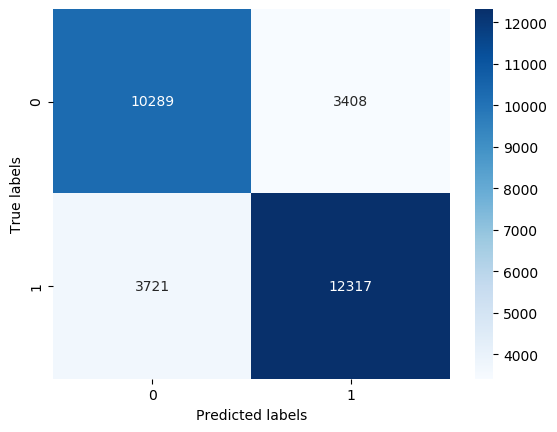

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
tree_cm = confusion_matrix(y_test, tree_pred)

# plot confusion matrix using seaborn heatmap
sns.heatmap(tree_cm, annot=True, cmap='Blues', fmt='g')

# set axis labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')


Feature ranking:
1. feature 3 age (0.237200)
2. feature 2 income (0.173131)
3. feature 4 membership_duration (0.131977)
4. feature 0 time (0.121900)
5. feature 1 amount_spent (0.121642)
6. feature 5 difficulty (0.084300)
7. feature 10 duration (0.073655)
8. feature 14 reward (0.016894)
9. feature 15 web (0.010760)
10. feature 16 email (0.008897)
11. feature 6 social (0.005606)
12. feature 7 mobile (0.004379)
13. feature 8 offer_type = _bogo (0.003469)
14. feature 13 offer_type = _discount (0.002176)
15. feature 12 offer_type = _informational (0.001640)
16. feature 17 gender = _F (0.001475)
17. feature 11 gender = _M (0.000898)
18. feature 9 gender = _O (0.000000)


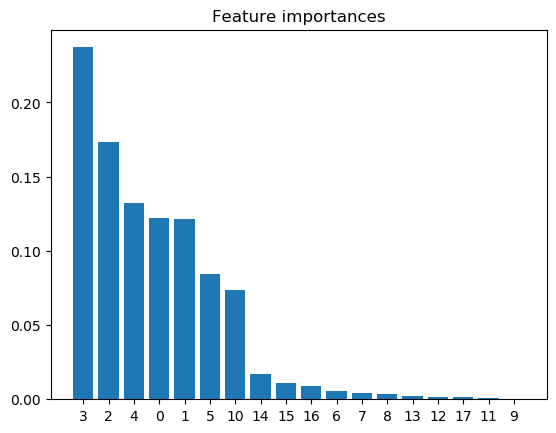

In [31]:
# get feature importances
tree_importances = tree_clf.feature_importances_

# sort feature importances in descending order
indices = np.argsort(tree_importances)[::-1]

# print out the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[f], tree_importances[indices[f]]))

# plot the feature importances
plt.title("Feature importances")
plt.bar(range(X.shape[1]), tree_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()


In [32]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(max_depth=2, random_state=0)
forest_clf = forest_clf.fit(X_train, y_train)

In [33]:
forest_pred = forest_clf.predict(X_test)

In [34]:
forest_f1 = f1_score(forest_pred, y_test)

In [35]:
forest_roc = roc_auc_score(forest_pred, y_test)

In [36]:
forest_recall = recall_score(forest_pred, y_test)

In [37]:
print(forest_f1, forest_roc, forest_recall)

0.726850605652759 0.7315997563545105 0.7894313696827949


Text(50.722222222222214, 0.5, 'True labels')

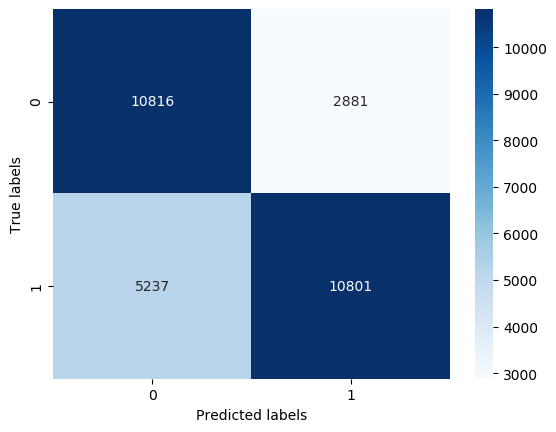

In [38]:
# calculate confusion matrix
forest_cm = confusion_matrix(y_test, forest_pred)

# plot confusion matrix using seaborn heatmap
sns.heatmap(forest_cm, annot=True, cmap='Blues', fmt='g')

# set axis labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

Feature ranking:
1. feature 3 age (0.236083)
2. feature 10 income (0.147993)
3. feature 7 membership_duration (0.141640)
4. feature 6 time (0.136716)
5. feature 5 amount_spent (0.128826)
6. feature 14 difficulty (0.115324)
7. feature 12 duration (0.035284)
8. feature 8 reward (0.029066)
9. feature 11 web (0.013486)
10. feature 13 email (0.006803)
11. feature 4 social (0.004770)
12. feature 1 mobile (0.003408)
13. feature 0 offer_type = _bogo (0.000508)
14. feature 2 offer_type = _discount (0.000084)
15. feature 16 offer_type = _informational (0.000005)
16. feature 17 gender = _F (0.000002)
17. feature 15 gender = _M (0.000000)
18. feature 9 gender = _O (0.000000)


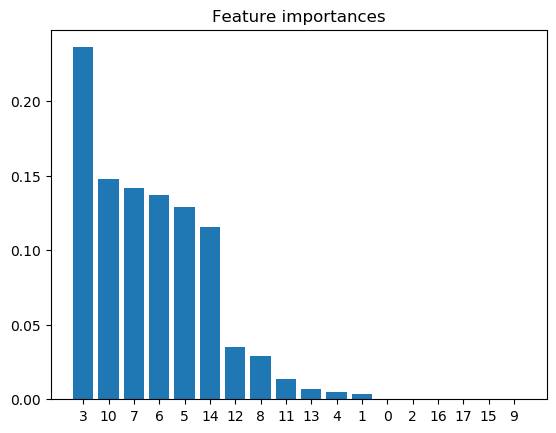

In [39]:
# get feature importances
forest_importances = forest_clf.feature_importances_

# sort feature importances in descending order
indices = np.argsort(forest_importances)[::-1]

# print out the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[f], forest_importances[indices[f]]))

# plot the feature importances
plt.title("Feature importances")
plt.bar(range(X.shape[1]), forest_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()


In [40]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
xgb_clf = xgb_clf.fit(X_train, y_train)

In [41]:
xgb_pred = xgb_clf.predict(X_test)

In [42]:
xgb_f1 = f1_score(xgb_pred, y_test)

In [43]:
xgb_roc = roc_auc_score(xgb_pred, y_test)

In [44]:
xgb_recall = recall_score(xgb_pred, y_test)

In [45]:
print(xgb_f1, xgb_roc, xgb_recall)

0.7707649131187677 0.742276230184119 0.7394592117323556


Text(50.722222222222214, 0.5, 'True labels')

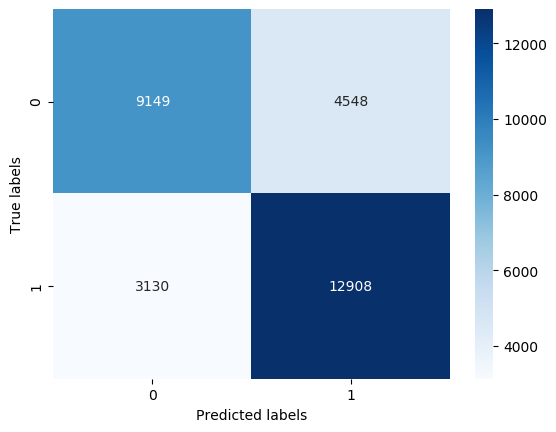

In [46]:
# calculate confusion matrix
xgb_cm = confusion_matrix(y_test, xgb_pred)

# plot confusion matrix using seaborn heatmap
sns.heatmap(xgb_cm, annot=True, cmap='Blues', fmt='g')

# set axis labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

Feature ranking:
1. feature 3 age (0.482154)
2. feature 5 income (0.294730)
3. feature 10 membership_duration (0.223117)
4. feature 17 time (0.000000)
5. feature 7 amount_spent (0.000000)
6. feature 1 difficulty (0.000000)
7. feature 2 duration (0.000000)
8. feature 4 reward (0.000000)
9. feature 6 web (0.000000)
10. feature 8 email (0.000000)
11. feature 16 social (0.000000)
12. feature 9 mobile (0.000000)
13. feature 11 offer_type = _bogo (0.000000)
14. feature 12 offer_type = _discount (0.000000)
15. feature 13 offer_type = _informational (0.000000)
16. feature 14 gender = _F (0.000000)
17. feature 15 gender = _M (0.000000)
18. feature 0 gender = _O (0.000000)


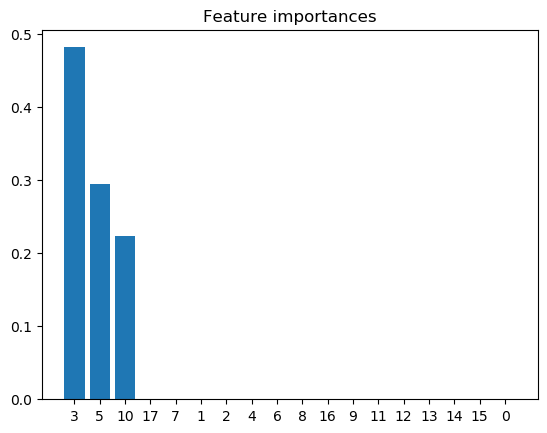

In [47]:
# get feature importances
xgb_importances = xgb_clf.feature_importances_

# sort feature importances in descending order
indices = np.argsort(xgb_importances)[::-1]

# print out the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[f], xgb_importances[indices[f]]))

# plot the feature importances
plt.title("Feature importances")
plt.bar(range(X.shape[1]), xgb_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()

In [48]:
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier()
lgb_clf = lgb_clf.fit(X_train, y_train)

In [49]:
lgb_pred = lgb_clf.predict(X_test)

In [50]:
lgb_f1 = f1_score(lgb_pred, y_test)

In [51]:
lgb_roc = roc_auc_score(lgb_pred, y_test)

In [52]:
lgb_recall = recall_score(lgb_pred, y_test)

In [53]:
print(lgb_f1, lgb_roc)

0.7941409092347115 0.7799310950698707


Text(50.722222222222214, 0.5, 'True labels')

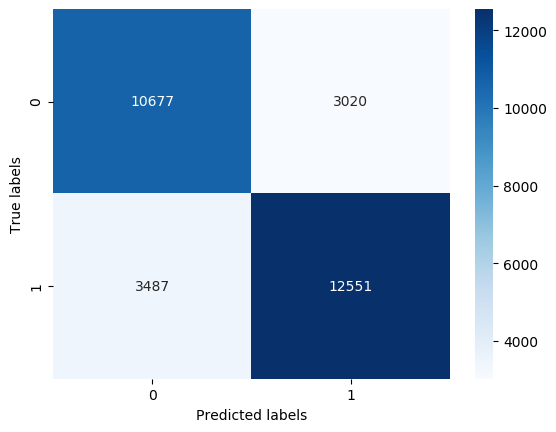

In [54]:
# calculate confusion matrix
lgb_cm = confusion_matrix(y_test, lgb_pred)

# plot confusion matrix using seaborn heatmap
sns.heatmap(lgb_cm, annot=True, cmap='Blues', fmt='g')

# set axis labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

Feature ranking:
1. feature 2 age (686.000000)
2. feature 1 income (634.000000)
3. feature 0 membership_duration (588.000000)
4. feature 3 time (370.000000)
5. feature 4 amount_spent (232.000000)
6. feature 10 difficulty (125.000000)
7. feature 5 duration (110.000000)
8. feature 6 reward (78.000000)
9. feature 8 web (75.000000)
10. feature 15 email (42.000000)
11. feature 17 social (19.000000)
12. feature 16 mobile (16.000000)
13. feature 7 offer_type = _bogo (11.000000)
14. feature 13 offer_type = _discount (10.000000)
15. feature 14 offer_type = _informational (3.000000)
16. feature 12 gender = _F (1.000000)
17. feature 9 gender = _M (0.000000)
18. feature 11 gender = _O (0.000000)


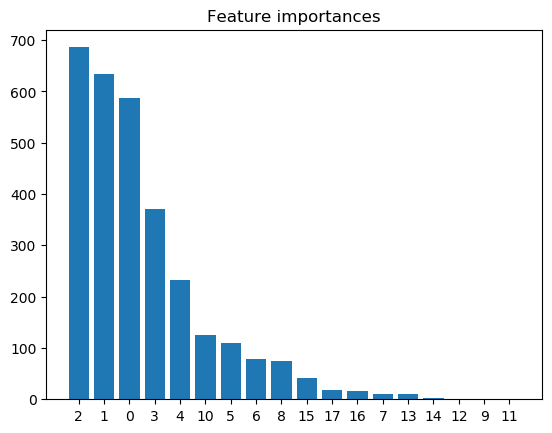

In [55]:
# get feature importances
lgb_importances = lgb_clf.feature_importances_

# sort feature importances in descending order
indices = np.argsort(lgb_importances)[::-1]

# print out the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[f], lgb_importances[indices[f]]))

# plot the feature importances
plt.title("Feature importances")
plt.bar(range(X.shape[1]), lgb_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score

In [57]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

models = []
models.append(('DT', tree.DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('LGBM', lgb.LGBMClassifier()))

In [58]:
f1_results = []
f1_names = []
scoring = 'f1'
kf = KFold(n_splits=10, random_state=0, shuffle=True)
for name, model in models:
    cv_results = cross_val_score(model, 
                                    X, 
                                    y, 
                                    scoring = scoring, 
                                    cv = kf)
    f1_results.append(abs(cv_results))
    f1_names.append(name)
    msg = "%s: %f (%f)" % (name, abs(cv_results.mean()), cv_results.std())
    print(abs(cv_results), msg)

[0.78383482 0.78529301 0.78669103 0.79140722 0.78036437 0.78668856
 0.78484387 0.7786687  0.78114816 0.77850455] DT: 0.783744 (0.003887)
[0.83883809 0.8437037  0.84186307 0.84092311 0.83709869 0.83981337
 0.83926672 0.83618458 0.84563089 0.8380531 ] RF: 0.840138 (0.002797)
[0.81615476 0.81831241 0.82185956 0.82355131 0.8181475  0.81547953
 0.81785375 0.81471165 0.82192641 0.81611386] XGB: 0.818411 (0.002893)
[0.79156672 0.79467537 0.79507785 0.80084904 0.79721519 0.78929177
 0.79368716 0.79522661 0.79713424 0.79392237] LGBM: 0.794865 (0.003015)


In [ ]:
recall_results = []
recall_names = []
scoring = 'recall'
kf = KFold(n_splits=10, random_state=0, shuffle=True)
for name, model in models:
    cv_results = cross_val_score(model, 
                                    X, 
                                    y, 
                                    scoring = scoring, 
                                    cv = kf)
    recall_results.append(abs(cv_results))
    recall_names.append(name)
    msg = "%s: %f (%f)" % (name, abs(cv_results.mean()), cv_results.std())
    print(abs(cv_results), msg)

[0.77126209 0.77495059 0.77559886 0.78501789 0.77330827 0.77295285
 0.76993138 0.76790867 0.77089515 0.77135615] DT: 0.773318 (0.004467)


In [ ]:
roc_results = []
roc_names = []
scoring = 'roc_auc'
kf = KFold(n_splits=10, random_state=0, shuffle=True)
for name, model in models:
    cv_results = cross_val_score(model, 
                                    X, 
                                    y, 
                                    scoring = scoring, 
                                    cv = kf)
    roc_results.append(abs(cv_results))
    roc_names.append(name)
    msg = "%s: %f (%f)" % (name, abs(cv_results.mean()), cv_results.std())
    print(abs(cv_results), msg)

In [114]:
#Show default parameters of Random Forest Classifier
rfc = RandomForestClassifier()
params = rfc.get_params()
params_df = pd.DataFrame(params, index=[0])
params_df.T

,0
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None


In [125]:
params = {'bootstrap': [True], 
          'max_depth': [3, 4, 5],
          'max_features': ['auto', 'sqrt'], 
          'min_samples_leaf': [3, 4, 5],
          'min_samples_split': [2, 3, 4],
          'n_estimators': [1400, 1600, 1800, 2000]}

In [133]:
from sklearn.model_selection import RandomizedSearchCV
clf = RandomizedSearchCV(estimator=rfc, 
                         param_distributions=params,
                         n_iter = 10,
                         scoring='recall',
                         cv = 10,
                         verbose=1)
clf.fit(X_val, y_val)
print("Best parameters:", clf.best_params_)
print("Best Recall: ", (clf.best_score_))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.5min finished


Best parameters: {'n_estimators': 1400, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 3, 'bootstrap': True}
Best Recall:  0.8379402805611221


In [ ]:
# 0.7508977955911822

# 0.7775134268537075 {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': True}

# {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}
# Best Recall:  0.7785142284569138

# Best parameters: {'n_estimators': 1400, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}
# Best Recall:  0.7769130260521042

# Best parameters: {'n_estimators': 1400, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 3, 'bootstrap': True}
# Best Recall:  0.8389402805611222

# Best parameters: {'n_estimators': 1600, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 3, 'bootstrap': True}
# Best Recall:  0.8383402805611222


In [127]:
best_rf = RandomForestClassifier(n_estimators = 1600, 
                       min_samples_split = 4, 
                       min_samples_leaf = 5, 
                       max_features = 'sqrt', 
                       max_depth = 3, 
                       bootstrap = True)

best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [128]:
best_pred = best_rf.predict(X_test)

In [129]:
best_f1 = f1_score(y_test, best_pred)
best_roc = roc_auc_score(y_test, best_pred)
best_recall = recall_score(y_test, best_pred)

print(best_f1, best_roc, best_recall)

0.7381792519407198 0.7678091143992416 0.8391496189330124


Text(50.722222222222214, 0.5, 'True labels')

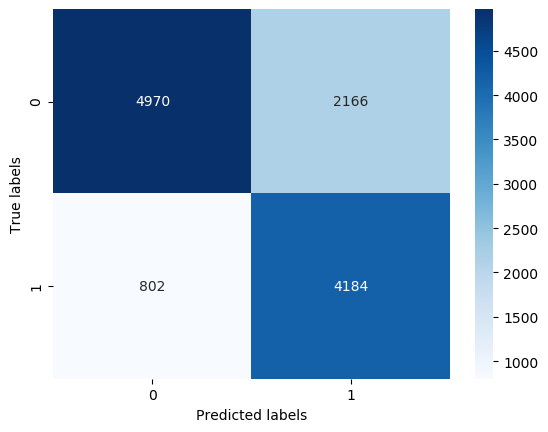

In [130]:
# calculate confusion matrix
best_cm = confusion_matrix(y_test, best_pred)

# plot confusion matrix using seaborn heatmap
sns.heatmap(best_cm, annot=True, cmap='Blues', fmt='g')

# set axis labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')